# Proyecto 3: Predicción de precios de propiedades

¡Bienvenidos al tercer proyecto de la carrera de Data Science de Acamica! 

En este proyecto vamos a seguir trabajando con el dataset de propiedades en venta publicadas en el portal [Properati](www.properati.com.ar). El objetivo en este caso armar nuestros primeros modelos para predecir el precio de las propiedades en dólares.

Las columnas que se agregan son:

* `barrios_match`: si coincide el barrio publicado con el geográfico vale 1, si no 0.

* `PH`, `apartment`, `house`: variables binarias que indican el tipo de propiedad.

* dummies de barrios: variables binarias con 1 o 0 según el barrio.

La métrica que vamos a usar para medir es RMSE (raíz del error cuadrático medio), cuya fórmula es:

$$RMSE = \sqrt{\frac{\sum_{t=1}^n (\hat y_t - y_t)^2}{n}}$$

In [1]:
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.3f' % x)
path_dataset = 'dataset/datos_properati_limpios_model.csv'
df = pd.read_csv(path_dataset)

In [2]:
print("El dataset que vamos a trabajar aquí tiene {} observaciones".format(df.shape[0]))

El dataset que vamos a trabajar aquí tiene 6376 observaciones


El objetivo de este proyecto es poder trabajar en el ajuste de modelos y su posterior evaluación.

Para empezar vamos a separar el `dataset` en un conjunto de entrenamiento (80%) y un conjunto de test (20%). 

**Separá el dataset** en `X_train`, `X_test`, `y_train` e `y_test` con el tamaño correspondiente

In [3]:
X = df.drop(['price_aprox_usd'], axis=1)
y = df['price_aprox_usd']

# Realizá la separación a continuación en esta celda
from sklearn.model_selection import train_test_split #Cargamos el train test split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2) #Separamos el dataset en un
#conjunto de entrenamiento y otro de test en el que este ultimo sea un 20%

print(X_train.shape, X_test.shape)

(5100, 58) (1276, 58)


## Árboles de decisión

Lo primero que vamos a hacer es entrenar un árbol de decisión y usar de métrica al `RMSE`. 

Para poder obtener el **RMSE** vamos a medir el `mean_squared_error` y obtener su raíz cuadrada. 

**Importá** `DecisionTreeRegressor` desde `sklearn.tree`.  

A continuación **entrená** el regresor con el conjunto de training


In [4]:
# En esta celda cargá el regresor y realizá el entrenamiento
from sklearn.tree import DecisionTreeRegressor #Cargamos el árbol de decisión

tree_reg = DecisionTreeRegressor() #Asignamos el objeto a una variable
tree_reg.fit(X_train, y_train) #Entrenamos el árbol con los datos de entrenamiento

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

Con el modelo entrenado **realizá la predicción** sobre el conjunto de test `X_test` y guardá el resultado en una variable `y_pred`.

In [5]:
# Acá realizá la predicción
y_pred = tree_reg.predict(X_test)

**Calculá el rmse** sacando la raíz cuadrada de `mean_squared_error` entre `y_test` e `y_pred` y **mostrá** el resultado

In [6]:
# En esta celda calculá el rmse
import numpy as np
from sklearn.metrics import mean_squared_error #Cargamos el MSE

RMSE = np.sqrt(mean_squared_error(y_test, y_pred)) #Calculamos el RMSE
RMSE

24927.96384356137

__Analizar el cambio en el RMSE a medida que es más profundo el árbol de decisión, tanto en training como en testing.__

Para esto, **iterá** de 5 en 5 en el parámetro `max_depth` y **observá** como impacta en el RMSE. 

**Creá** dos arreglos `rmses_train` y `rmses_test` para ir guardando los **rmse** de cada profundidad

In [7]:
rmses_train = [] #Creamos las listas vacias
rmses_test = []

for i in range(1,30,5):
    tree_reg1 = DecisionTreeRegressor(max_depth=i) #Configuramos el árbol para que tenga una profundidad i
    #iterando de 5 en 5 la profundidad hasta 30
    tree_reg1.fit(X_train, y_train)
    y_pred1 = tree_reg1.predict(X_train) #Predecimos sobre el conjunto X de entrenamiento
    RMSE1 = np.sqrt(mean_squared_error(y_train, y_pred1))
    rmses_train.append(RMSE1) #Guardamos cada valor de RMSE en la lista creada

for i in range(1,30,5):
    tree_reg2 = DecisionTreeRegressor(max_depth=i)
    tree_reg2.fit(X_train, y_train)
    y_pred2 = tree_reg2.predict(X_test) #Predecimos sobre el conjunto X de testeo
    RMSE2 = np.sqrt(mean_squared_error(y_test, y_pred2))
    rmses_test.append(RMSE2)

print (rmses_train,'\n\n', rmses_test)

[26771.441339088728, 20295.628376024324, 14359.187035171184, 8281.661614888695, 4333.073550498337, 1300.5316218813632] 

 [26476.290513611246, 21596.52800800568, 22667.16597378208, 24392.29661304359, 24878.56060415961, 25362.41783320747]


Ahora graficamos los valores que guardamos en los arreglos `rmses_train` y `rmses_test`

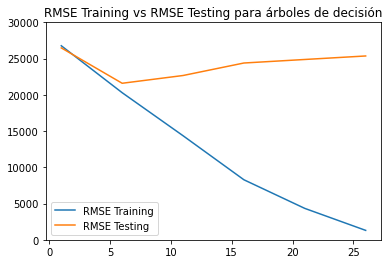

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline 
plt.plot(range(1,30, 5), rmses_train, label='RMSE Training')
plt.plot(range(1,30, 5), rmses_test, label='RMSE Testing')
plt.ylim((0, 30000))
plt.legend(loc="best")
plt.title("RMSE Training vs RMSE Testing para árboles de decisión")
plt.show()

Podemos ver aquí como el modelo presenta sobreajuste dado que a mayor complejidad (en este caso, mayor profundidad del árbol) más diferencia entre los resultados de training y testing. También observamos como la curva de testing decrece y luego vuelvo a crecer. El punto donde se minimiza está relacionado con el tradeoff entre sesgo y varianza que vamos a ver en la próxima unidad.

## KNN

**Entrená un knn** y nuevamente medir el **rmse** en el conjunto de testing


In [9]:
# Realizá el entrenamiento y el cálculo de rmse en esta celda
from sklearn.neighbors import KNeighborsRegressor

knn = KNeighborsRegressor() #Cargamos el objeto regresor a una variable knn
knn.fit(X_train, y_train) #Entrenamos el modelo
y_pred = knn.predict(X_test) #Predecimos con el modelo los datos X de testeo
RMSE = np.sqrt(mean_squared_error(y_test, y_pred)) #Calculamos el RMSE
RMSE

22969.21406969986

__Analizar el cambio en el RMSE a medida que consideramos más vecinos para KNN, tanto en training como en testing.__

Para esto, **iterá** incrementando de a uno el parámetro `n_neighbors` y **observá** como impacta en el RMSE. 

**Creá** dos arreglos `rmses_train` y `rmses_test` para ir guardando los **rmse** de cada profundidad

In [10]:
# Calculá los cambio en el rmse en esta celda
rmses_train = [] #Creamos las listas vacias
rmses_test = []

for i in range(1,30,1):
    knn1 = KNeighborsRegressor(n_neighbors=i) #Asigno un valor i a la cantidad de vecinos
    #para que se vayan iterando de a uno hasta llegar a un valor maximo de 30
    knn1.fit(X_train, y_train)
    y_pred3 = knn1.predict(X_train)
    RMSE3 = np.sqrt(mean_squared_error(y_train, y_pred3))
    rmses_train.append(RMSE3) #Adjunto cada valor de RMSE a la lista creada

for i in range(1,30,1):
    knn2 = KNeighborsRegressor(n_neighbors=i)
    knn2.fit(X_train, y_train)
    y_pred4 = knn2.predict(X_test)
    RMSE4 = np.sqrt(mean_squared_error(y_test, y_pred4))
    rmses_test.append(RMSE4)
    
print (rmses_train,'\n\n', rmses_test)

[718.5530523347652, 13717.40798317397, 16272.013864548664, 17815.59322448986, 18726.51606432184, 19346.672112698438, 19729.301251895657, 20103.165571949557, 20443.145662510287, 20662.663198019436, 20881.785346421115, 21038.75960087545, 21190.314989573806, 21299.105568366966, 21387.74276707284, 21485.02156480733, 21609.690226101884, 21721.63447030005, 21832.052587367034, 21917.41311400407, 22003.196891763902, 22069.964485114717, 22132.001731685014, 22198.230990134718, 22275.70233769462, 22335.119632699047, 22407.347157878354, 22444.691146077388, 22499.118598216875] 

 [27652.28789184441, 25042.972883226685, 24059.44422527212, 23136.989233474003, 22969.21406969986, 22877.81432698678, 22912.239911419118, 23033.57979080123, 23024.98709777225, 23027.480293053824, 23029.549755270134, 23022.76981096138, 23082.974788555057, 23137.05447315904, 23111.175350542177, 23054.572193262833, 22991.442999546194, 23040.816049577654, 23057.933924681616, 23099.661968940516, 23089.88760212126, 23102.35726733

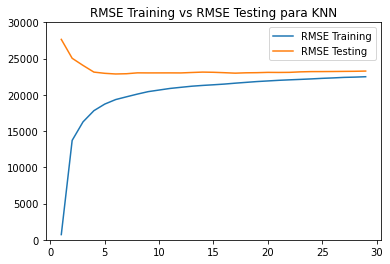

In [11]:
plt.plot(range(1,30, 1), rmses_train, label='RMSE Training')
plt.plot(range(1,30, 1), rmses_test, label='RMSE Testing')
plt.ylim((0, 30000))
plt.legend(loc="best")
plt.title("RMSE Training vs RMSE Testing para KNN")
plt.show()

**Calcular el RMSE promedio del resultado de cross validation para un árbol de decisión. 
Como parámetros deberás usar:**
- 10 folds
- profundidad 5
- scoring neg_mean_squared_error.

El árbol de decisión guardalo en una variable llamada `regressor` para poder reutilizarla luego.

Atención: `cross_validation_score` de `scikit-learn` usá la métrica `neg_mean_squared_error` (NMSE) en vez de `mean_square_error` (MSE). 

`NMSE` es lo mismo que `MSE` pero con un signo negativo. 

Como nosotros queremos obtener el `MSE` para calcular sobre él el `RMSE`, vamos a definir un método `nmsq2rmse` para hacer esa conversión de `NMSE` a `MSE`
.

In [12]:
def nmsq2rmse(score):
    return np.sqrt(-score)

In [13]:
# Calculá en esta celda los cross_val_score
from sklearn.model_selection import cross_val_score

regressor = DecisionTreeRegressor(max_depth=5) #Asigno una variable al árbol con una profundidad de 5
score = cross_val_score(regressor, X_train, y_train, 
                       scoring='neg_mean_squared_error', cv=10) #Realizo el cross validation sobre
#el árbol, le paso los datos X e y de entrenamiento, el score lo ejecuto usando el NMSE y hago 10 folds 
nmsq2rmse(score) #Llamo a la funcion creada en la celda anterior para convertir el NMSE en RMSE

array([21735.29552261, 21217.77145156, 22826.8054985 , 22030.7010916 ,
       23515.35675561, 21950.20331563, 24198.81517267, 22701.60214938,
       20451.49327438, 21067.34958916])

Para ver el resultado final, reentrenamos al regresor y mostramos en un dataframe la comparación entre los valores reales, los predichos y su diferencia

In [14]:
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)
val_real = pd.Series(y_test.values)
val_pred = pd.Series(y_pred)

In [15]:
predicciones = pd.concat([val_real.rename('Valor real'),val_pred.rename('Valor Pred') ,abs(val_real-val_pred).rename('Dif(+/-)')] ,  axis=1)

In [16]:
predicciones.head(10)

,Valor real,Valor Pred,Dif(+/-)
0,134000.000,137312.328,3312.328
1,144900.000,121619.473,23280.527
2,68500.000,75859.384,7359.384
3,165000.000,140819.973,24180.027
4,75000.000,84141.254,9141.254
5,150000.000,109532.065,40467.935
6,89000.000,85465.003,3534.997
7,163000.000,137312.328,25687.672
8,165000.000,147082.154,17917.846
9,149000.000,134234.705,14765.295
